<a href="https://colab.research.google.com/github/Awerito/data-cience-dataset/blob/master/model_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://gitlab.com/Ezfeik/cienciadatos.git

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install tensorflow-object-detection-api

# Carga del Modelo

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)
                    
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = 'caca.jpg'

# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = 'cienciadatos/exported-models/centernet_model'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = 'cienciadatos/exported-models/centernet_model/saved_model/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = 0.60

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
tf.gfile = tf.io.gfile
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)


Done! Took 87.71678733825684 seconds


# Visualización

Running inference for caca.jpg... Done


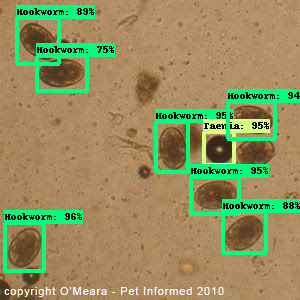

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=MIN_CONF_THRESH,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
from google.colab.patches import cv2_imshow
cv2_imshow(image_with_detections)
# CLOSES WINDOW ONCE KEY IS PRESSED
cv2.waitKey(0)
# CLEANUP
cv2.destroyAllWindows()
